In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random
import matplotlib.ticker as ticker
import pandas as pd


seeds= list(range(1000, 1020))
epis= ["Sars", "H1N1", "Covid", "ALL"]
epiIdx=  3###
n= 93
strains= 1
if epis[epiIdx]== "ALL":
    strains= 3

preAs= []
sumPreA= 0
for seed in seeds:
    fileName= f"AA/AA_{epis[epiIdx]}__{strains}_{n}_{seed}" #SARS_H1N1_COVID
    npzfile = np.load("results/"+fileName+".npz")
    PreA= torch.tensor(npzfile["Apre"])
    sumPreA+= PreA
    AdjCurTen= torch.tensor(npzfile["A"])
    AdjCur= AdjCurTen.numpy()
    signal= npzfile["signal"]
    predSignal= npzfile["predSignal"]
    preAs.append(PreA)
sumPreA= sumPreA/len(seeds)
sumPreA= sumPreA+sumPreA.T
preAs.append(sumPreA)
preAs.append(AdjCurTen)
for i in preAs:
    for j in preAs:
        print(np.round(evaluate.pearson_correlation(i, j).item(),2), end= ", ")
    print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0, 0.91, 0.89, 0.91, 0.73, 0.86, 0.94, 0.93, 0.94, 0.93, 0.76, 0.78, 0.79, 0.89, 0.95, 0.88, 0.73, 0.71, 0.84, 0.76, 0.68, 0.14, 
0.91, 1.0, 0.9, 0.93, 0.79, 0.91, 0.96, 0.95, 0.93, 0.95, 0.78, 0.81, 0.83, 0.94, 0.97, 0.92, 0.68, 0.72, 0.89, 0.83, 0.7, 0.14, 
0.89, 0.9, 1.0, 0.94, 0.74, 0.81, 0.93, 0.94, 0.95, 0.93, 0.71, 0.69, 0.72, 0.84, 0.94, 0.83, 0.68, 0.68, 0.84, 0.74, 0.67, 0.13, 
0.91, 0.93, 0.94, 1.0, 0.73, 0.83, 0.93, 0.93, 0.94, 0.94, 0.73, 0.72, 0.76, 0.86, 0.93, 0.84, 0.67, 0.67, 0.85, 0.76, 0.67, 0.14, 
0.73, 0.79, 0.74, 0.73, 1.0, 0.88, 0.77, 0.78, 0.76, 0.77, 0.95, 0.91, 0.9, 0.83, 0.79, 0.83, 0.73, 0.81, 0.86, 0.96, 0.66, 0.09, 
0.86, 0.91, 0.81, 0.83, 0.88, 1.0, 0.9, 0.88, 0.85, 0.87, 0.88, 0.92, 0.94, 0.95, 0.91, 0.96, 0.7, 0.81, 0.92, 0.91, 0.7, 0.11, 
0.94, 0.96, 0.93, 0.93, 0.77, 0.9, 1.0, 0.96, 0.96, 0.96, 0.78, 0.8, 0.82, 0.92, 0.98, 0.92, 0.7, 0.73, 0.88, 0.8, 0.7, 0.14, 


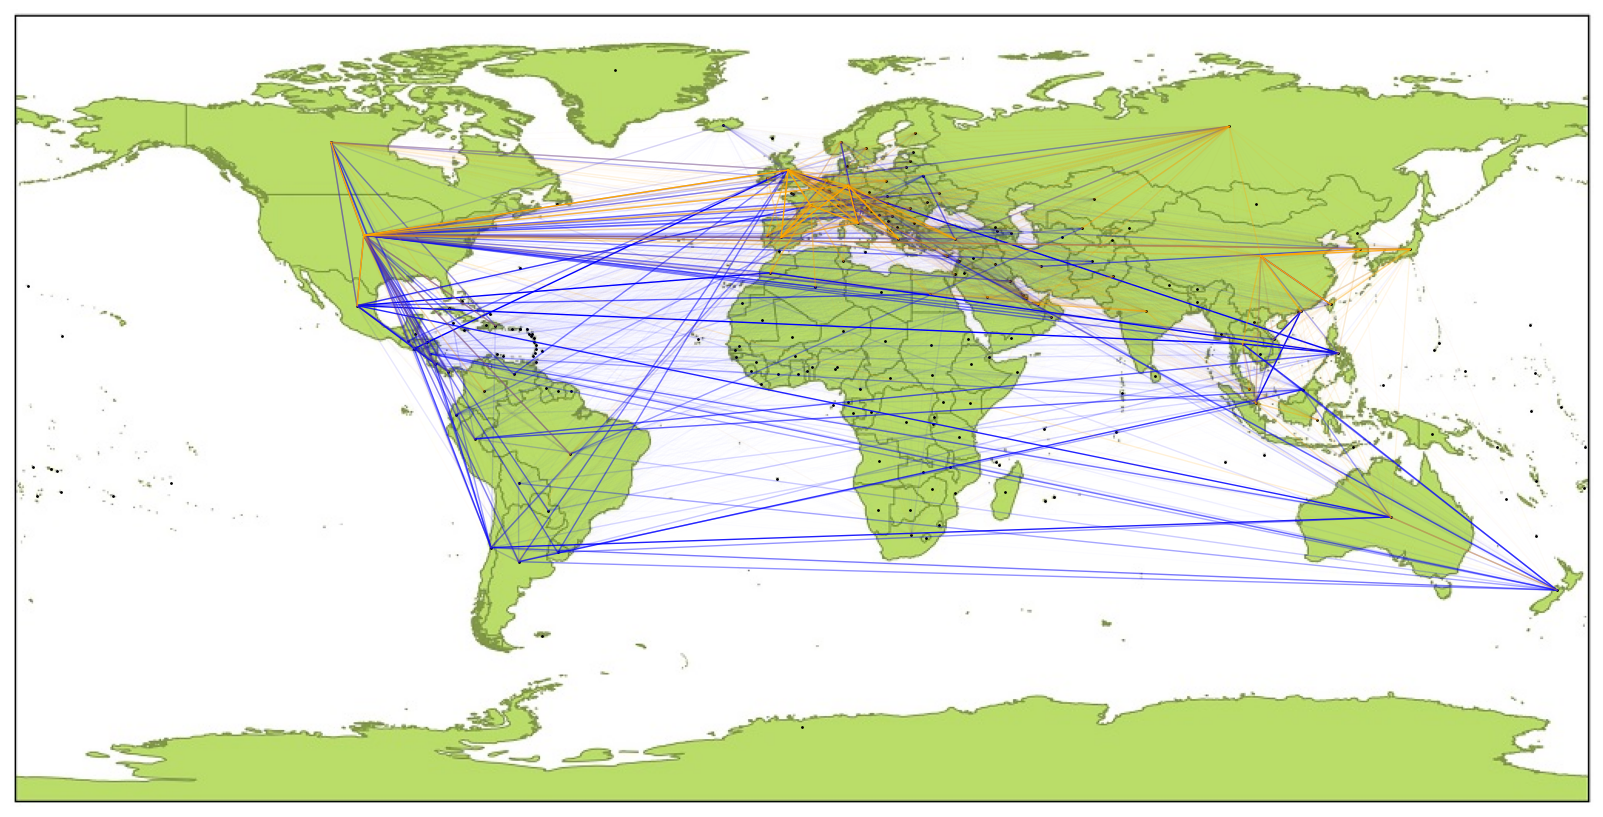

In [95]:


def plot_on_map(PreANp, realNp, lineWeightRatio= 10):
    pop_file_path = 'testData/Country_Population_final.csv'
    data = pd.read_csv(pop_file_path)
    popIdxData = np.genfromtxt(f'testData/test_pop_inx.csv', delimiter=',', skip_header=0)
    popIdxData= [int(i) for i in popIdxData]
    popIdxDataNp= np.array(popIdxData, dtype= "int")

    plt.figure(figsize=(10.28*2, 5.18*2))
    coordinatesArrayTmp= np.stack([data["loc_x"].to_numpy(), data["loc_y"].to_numpy()], axis= 1)
    img = plt.imread("WorldEqdc.jpg")
    plt.imshow(img)
    coordinatesArray= coordinatesArrayTmp.copy()
    coordinatesArray[:, 1]= 2.835*coordinatesArrayTmp[:, 1]+1028/2
    coordinatesArray[:, 0]= -2.835*coordinatesArrayTmp[:, 0]+518/2
    plt.scatter(coordinatesArray[:, 1], coordinatesArray[:, 0], color='black', s=1, label="Locations")
    # for i in range(len(popName)):
    #     plt.text(coordinatesArray[i, 1] + 0.1,
    #             coordinatesArray[i, 0] + 0.1, f"{popName[i]}", fontsize=10, color='black')  # Annotate points
    for i in range(realNp.shape[0]):
        for j in range(i + 1, realNp.shape[1]):  # Only upper triangle (undirected graph)
            if (realNp[j, i]+realNp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (realNp[j, i]+realNp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='blue', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)
    for i in range(PreANp.shape[0]):
        for j in range(i + 1, PreANp.shape[1]):  # Only upper triangle (undirected graph)
            if (PreANp[j, i]+PreANp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (PreANp[j, i]+PreANp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='orange', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)

    plt.axis('off')

TopNum= 50
APreNp= ((sumPreA)).cpu().detach().numpy()
rankedAPre= np.sort(APreNp.flatten())
APreNp= APreNp/np.linalg.norm(APreNp)
ATrueNp= AdjCur/np.linalg.norm(AdjCur)
plot_on_map( ATrueNp, APreNp, 10)

In [77]:
print(signal.shape)
sumSignal= signal.sum(axis= 1)
sumSignal= sumSignal.sum(axis= 1)

(93, 1, 80)


In [87]:
sumSignal= signal.sum(axis= 1)
sumSignal= sumSignal.sum(axis= 1)
sortIdx= np.argsort(sumSignal)
selectNode= sortIdx[:]
AdjCurTen2= AdjCurTen/torch.norm(AdjCurTen)

selectsumPreA= sumPreA[selectNode, :]
selectsumPreA= selectsumPreA[:, selectNode]
selectAdjCurTen2= AdjCurTen2[selectNode, :]
selectAdjCurTen2= selectAdjCurTen2[:, selectNode]
print(selectAdjCurTen2.shape)

print(evaluate.pearson_correlation(selectsumPreA, selectAdjCurTen2))

torch.Size([93, 93])
tensor(0.1039)


In [55]:
print(sumSignal[sortIdx[-1]])

0.017069317


In [ ]:
PearsonRankedScores= []

for TrustDegree in range(1, 1000):
    tmpScore= evaluate.pearson_correlation(sumPreA*(sumPreA>rankedAPre[-TrustDegree]), AdjCurTen2*(sumPreA>rankedAPre[-TrustDegree]))
    PearsonRankedScores.append(tmpScore.item())

In [37]:
for i in range(len(top100List)):
    plt.plot(top100List[i][:80])
plt.xlabel("Top K")


NameError: name 'top100List' is not defined

In [157]:
top100List.append(PearsonRankedScores)

In [138]:
top100List= []